In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample

np.random.seed(42)
n = 1200

genders = ["Male", "Female", "Non-binary"]
ethnicities = ["Group_A", "Group_B", "Group_C"]
degrees = ["High School", "Bachelors", "Masters", "PhD"]

data = pd.DataFrame({
    "Applicant_ID": range(1, n+1),
    "Gender": np.random.choice(genders, n, p=[0.5, 0.45, 0.05]),
    "Ethnicity": np.random.choice(ethnicities, n, p=[0.4, 0.35, 0.25]),
    "Age": np.random.randint(20, 60, n),
    "Degree": np.random.choice(degrees, n, p=[0.2, 0.5, 0.25, 0.05]),
    "Years_Experience": np.random.randint(0, 20, n),
    "Skill_Test_Score": np.random.randint(40, 100, n)
})

# Introduce bias: Group_A and Males slightly higher shortlist rate
data["Shortlisted"] = np.where(
    ((data["Ethnicity"] == "Group_A") & (data["Skill_Test_Score"] > 70)) |
    ((data["Gender"] == "Male") & (data["Years_Experience"] > 5)),
    np.random.choice([1, 0], n, p=[0.7, 0.3]),
    np.random.choice([1, 0], n, p=[0.4, 0.6])
)

data.head()

,Applicant_ID,Gender,Ethnicity,Age,Degree,Years_Experience,Skill_Test_Score,Shortlisted
0,1,Male,Group_C,50,High School,18,84,1
1,2,Non-binary,Group_A,46,Bachelors,4,59,0
2,3,Female,Group_A,30,High School,17,63,0
3,4,Female,Group_A,57,Masters,19,66,0
4,5,Male,Group_B,24,Bachelors,11,69,1


3. Detecting Bias in Data

Gender Distribution:
Gender
Male          0.490000
Female        0.460833
Non-binary    0.049167
Name: proportion, dtype: float64

Ethnicity Distribution:
Ethnicity
Group_A    0.390000
Group_B    0.368333
Group_C    0.241667
Name: proportion, dtype: float64


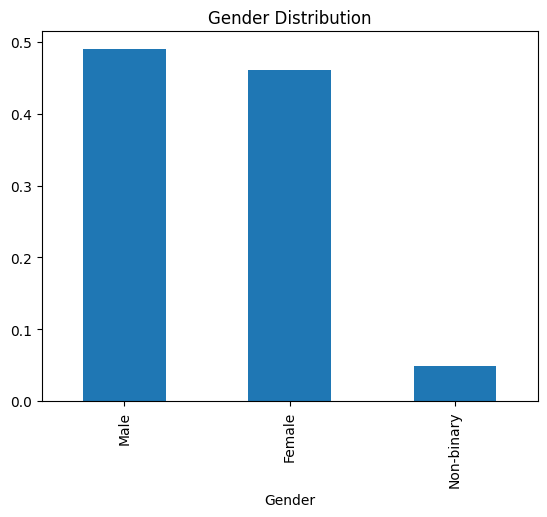

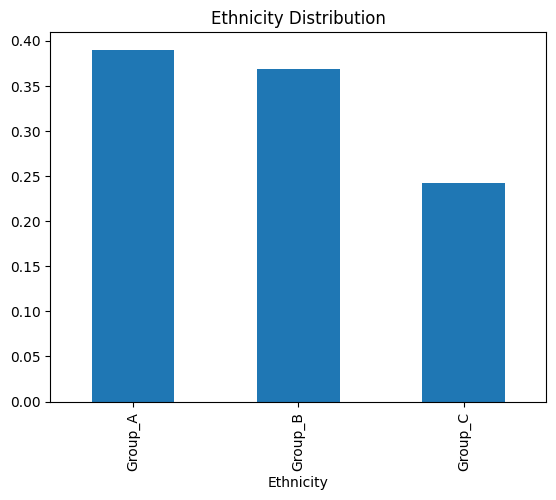

In [2]:
# Distribution by Gender
gender_counts = data["Gender"].value_counts(normalize=True)
print("Gender Distribution:")
print(gender_counts)

# Distribution by Ethnicity
ethnicity_counts = data["Ethnicity"].value_counts(normalize=True)
print("\nEthnicity Distribution:")
print(ethnicity_counts)

# Bar charts
gender_counts.plot(kind='bar', title='Gender Distribution')
plt.show()

ethnicity_counts.plot(kind='bar', title='Ethnicity Distribution')
plt.show()

Shortlist Rates by Gender:
Gender
Female        0.446655
Male          0.632653
Non-binary    0.355932
Name: Shortlisted, dtype: float64

Shortlist Rates by Ethnicity:
Ethnicity
Group_A    0.602564
Group_B    0.475113
Group_C    0.510345
Name: Shortlisted, dtype: float64

Chi-square test Gender-Shortlisted p-value: 4.9492276128426605e-11
Chi-square test Ethnicity-Shortlisted p-value: 0.00040008238090522133


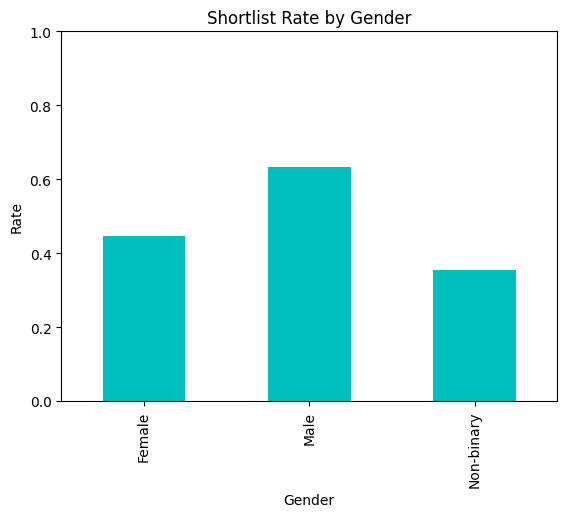

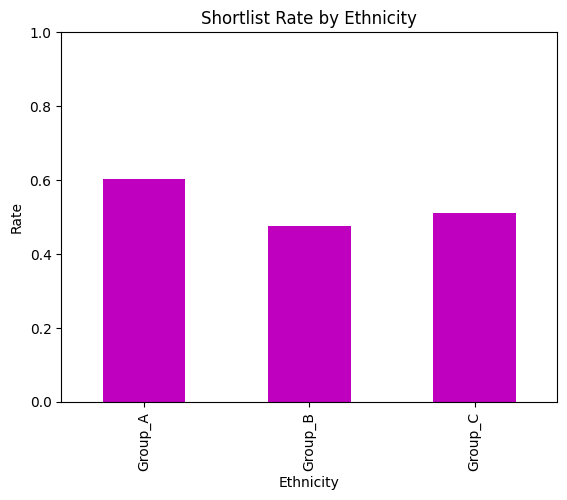

In [3]:
# Shortlist rates by Gender
gender_shortlist_rate = data.groupby("Gender")["Shortlisted"].mean()
print("Shortlist Rates by Gender:")
print(gender_shortlist_rate)

# Shortlist rates by Ethnicity
ethnicity_shortlist_rate = data.groupby("Ethnicity")["Shortlisted"].mean()
print("\nShortlist Rates by Ethnicity:")
print(ethnicity_shortlist_rate)

# Chi-square test for Gender and Shortlisted
contingency_gender = pd.crosstab(data["Gender"], data["Shortlisted"])
chi2_g, p_g, dof_g, expected_g = chi2_contingency(contingency_gender)
print(f"\nChi-square test Gender-Shortlisted p-value: {p_g}")

# Chi-square test for Ethnicity and Shortlisted
contingency_ethnicity = pd.crosstab(data["Ethnicity"], data["Shortlisted"])
chi2_e, p_e, dof_e, expected_e = chi2_contingency(contingency_ethnicity)
print(f"Chi-square test Ethnicity-Shortlisted p-value: {p_e}")

# Plot shortlist rates
gender_shortlist_rate.plot(kind='bar', color='c', title='Shortlist Rate by Gender', ylim=(0,1))
plt.ylabel('Rate')
plt.show()

ethnicity_shortlist_rate.plot(kind='bar', color='m', title='Shortlist Rate by Ethnicity', ylim=(0,1))
plt.ylabel('Rate')
plt.show()

4. Detecting Algorithmic Bias

In [4]:
# Encode categorical features
X = pd.get_dummies(data[["Gender", "Ethnicity", "Degree", "Years_Experience", "Skill_Test_Score", "Age"]], drop_first=True)
y = data["Shortlisted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression
model = LogisticRegression(solver='liblinear', max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Overall Accuracy: 0.656


In [5]:
def calculate_metrics(df, true_labels, preds, group_col):
    results = {}
    for group in df[group_col].unique():
        idx = df[group_col] == group
        tn, fp, fn, tp = confusion_matrix(true_labels[idx], preds[idx]).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        tpr = tp / (tp + fn) if (tp + fn) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        results[group] = {"Accuracy": accuracy, "TPR": tpr, "FPR": fpr}
    return pd.DataFrame(results)

# Prepare test data with group columns
df_test = X_test.copy()
df_test["Gender"] = data.loc[y_test.index, "Gender"]
df_test["Ethnicity"] = data.loc[y_test.index, "Ethnicity"]

metrics_gender = calculate_metrics(df_test, y_test, y_pred, "Gender")
metrics_ethnicity = calculate_metrics(df_test, y_test, y_pred, "Ethnicity")

print("Metrics by Gender:")
print(metrics_gender)

print("\nMetrics by Ethnicity:")
print(metrics_ethnicity)

Metrics by Gender:
            Female      Male  Non-binary
Accuracy  0.655172  0.645349    0.785714
TPR       0.450000  0.899083    0.500000
FPR       0.170213  0.793651    0.100000

Metrics by Ethnicity:
           Group_B   Group_C   Group_A
Accuracy  0.585938  0.662921  0.713287
TPR       0.467742  0.720930  0.863636
FPR       0.303030  0.391304  0.527273


In [6]:
coef = pd.Series(model.coef_[0], index=X.columns)
print("Feature Importances:")
print(coef.sort_values(ascending=False))

Feature Importances:
Gender_Male           0.737495
Degree_Masters        0.097683
Years_Experience      0.033515
Skill_Test_Score      0.013866
Age                  -0.007745
Degree_PhD           -0.120165
Degree_High School   -0.135433
Gender_Non-binary    -0.184010
Ethnicity_Group_C    -0.327087
Ethnicity_Group_B    -0.538284
dtype: float64


5. Mitigating Bias

In [14]:
# Separate groups
df_minority = data[data['Ethnicity'] == 'Group_C']
df_majority = data[data['Ethnicity'] != 'Group_C']

# Upsample minority
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine to get balanced dataset
data_balanced = pd.concat([df_majority, df_minority_upsampled])

data_balanced = data_balanced.reset_index(drop=True)
# Check new proportions
print("New Ethnicity Distribution After Balancing:")
print(data_balanced['Ethnicity'].value_counts(normalize=True))

# Check shortlist rates post balancing
print("\nShortlist rates by Ethnicity after balancing:")
print(data_balanced.groupby("Ethnicity")["Shortlisted"].mean())

New Ethnicity Distribution After Balancing:
Ethnicity
Group_C    0.500000
Group_A    0.257143
Group_B    0.242857
Name: proportion, dtype: float64

Shortlist rates by Ethnicity after balancing:
Ethnicity
Group_A    0.602564
Group_B    0.475113
Group_C    0.529670
Name: Shortlisted, dtype: float64


In [15]:
# Prepare new dataset
X_balanced = pd.get_dummies(data_balanced[["Gender", "Ethnicity", "Degree", "Years_Experience", "Skill_Test_Score", "Age"]], drop_first=True)
y_balanced = data_balanced["Shortlisted"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

model_bal = LogisticRegression(solver='liblinear', max_iter=200)
model_bal.fit(X_train_b, y_train_b)

y_pred_b = model_bal.predict(X_test_b)
print(f"Balanced Model Accuracy: {accuracy_score(y_test_b, y_pred_b):.3f}")

Balanced Model Accuracy: 0.612


In [16]:
df_test_b = X_test_b.copy()
df_test_b["Gender"] = data_balanced.loc[y_test_b.index, "Gender"]
df_test_b["Ethnicity"] = data_balanced.loc[y_test_b.index, "Ethnicity"]

metrics_gender_b = calculate_metrics(df_test_b, y_test_b, y_pred_b, "Gender")
metrics_ethnicity_b = calculate_metrics(df_test_b, y_test_b, y_pred_b, "Ethnicity")

print("Balanced Model Metrics by Gender:")
print(metrics_gender_b)

print("\nBalanced Model Metrics by Ethnicity:")
print(metrics_ethnicity_b)

Balanced Model Metrics by Gender:
            Female      Male  Non-binary
Accuracy  0.575875  0.640449    0.681818
TPR       0.391304  0.981707    0.142857
FPR       0.274648  0.902913    0.066667

Balanced Model Metrics by Ethnicity:
           Group_C   Group_A   Group_B
Accuracy  0.607273  0.611111  0.622047
TPR       0.693333  0.795181  0.698113
FPR       0.496000  0.639344  0.432432


Fairness Metrics and Evaluation

In [17]:
def demographic_parity(y_true, y_pred, groups):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': groups}).groupby('group')['y_pred'].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, groups):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': groups})
    group_tprs = {}
    for g in df['group'].unique():
        subset = df[df['group'] == g]
        tp = ((subset['y_pred'] == 1) & (subset['y_true'] == 1)).sum()
        fn = ((subset['y_pred'] == 0) & (subset['y_true'] == 1)).sum()
        tpr = tp / (tp + fn) if (tp + fn) else 0
        group_tprs[g] = tpr
    return max(group_tprs.values()) - min(group_tprs.values())

def disparate_impact(y_true, y_pred, groups, privileged_group):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': groups}).groupby('group')['y_pred'].mean()
    if privileged_group not in rates:
        return None
    priv_rate = rates[privileged_group]
    min_rate = rates.min()
    return min_rate / priv_rate if priv_rate > 0 else None

In [18]:
# Baseline Model
dp_base = demographic_parity(y_test, y_pred, df_test["Ethnicity"])
eo_base = equal_opportunity(y_test, y_pred, df_test["Ethnicity"])
di_base = disparate_impact(y_test, y_pred, df_test["Ethnicity"], privileged_group="Group_A")

print(f"Baseline Model:\nDemographic Parity Difference: {dp_base:.3f}\nEqual Opportunity Difference: {eo_base:.3f}\nDisparate Impact Ratio: {di_base:.3f}")

# Balanced Model
dp_bal = demographic_parity(y_test_b, y_pred_b, df_test_b["Ethnicity"])
eo_bal = equal_opportunity(y_test_b, y_pred_b, df_test_b["Ethnicity"])
di_bal = disparate_impact(y_test_b, y_pred_b, df_test_b["Ethnicity"], privileged_group="Group_A")

print(f"\nBalanced Model:\nDemographic Parity Difference: {dp_bal:.3f}\nEqual Opportunity Difference: {eo_bal:.3f}\nDisparate Impact Ratio: {di_bal:.3f}")

Baseline Model:
Demographic Parity Difference: 0.351
Equal Opportunity Difference: 0.396
Disparate Impact Ratio: 0.521

Balanced Model:
Demographic Parity Difference: 0.186
Equal Opportunity Difference: 0.102
Disparate Impact Ratio: 0.745
